## Лаба 3 Классификация. Нейронные сети
## Цель работы: изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard. 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка датасета wine quality
wine = fetch_openml('wine_quality', version=1, as_frame=True)
df = wine.frame

# Просмотр информации о датасете
print("Информация о датасете:")
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о столбцах:")
print(df.info())
print("\nСтатистическое описание:")
print(df.describe())

Информация о датасете:
Размер датасета: (6497, 12)

Первые 5 строк:
   fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  qualit

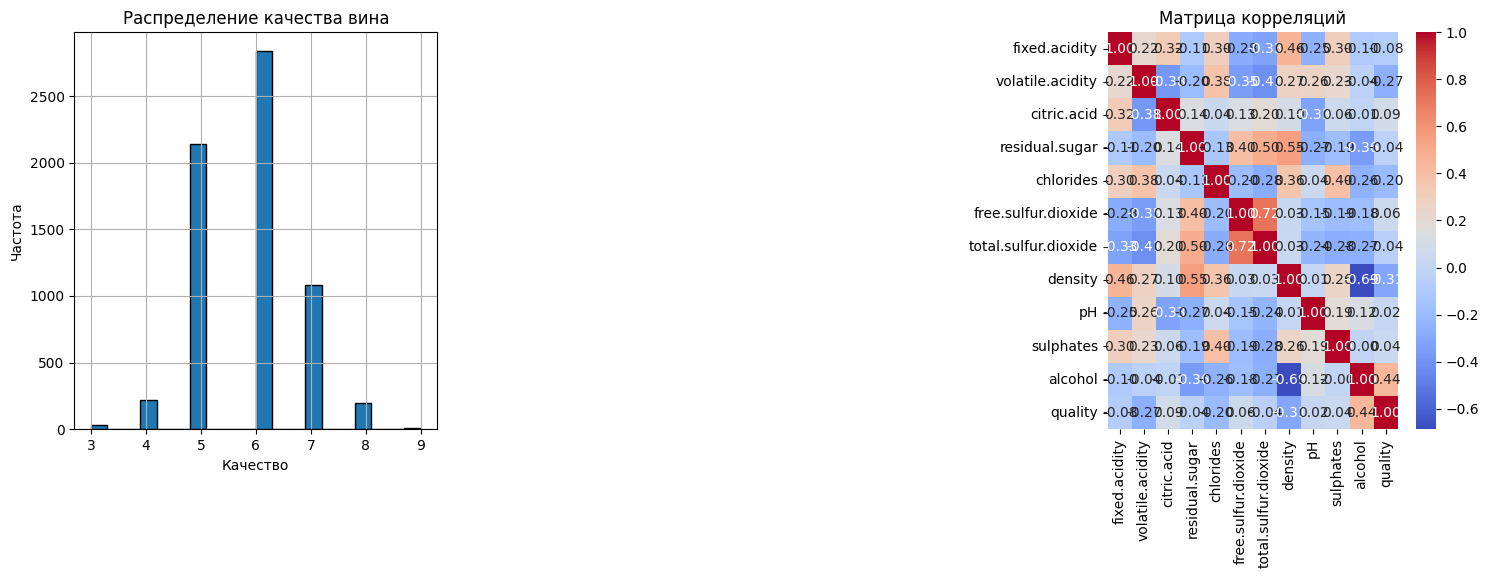


Распределение целевой переменной:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


In [13]:
# Визуализация распределения целевой переменной (quality)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['quality'].hist(bins=20, edgecolor='black')
plt.title('Распределение качества вина')
plt.xlabel('Качество')
plt.ylabel('Частота')


# Матрица корреляций
plt.subplot(2, 3, 3)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

# Анализ баланса классов
print("\nРаспределение целевой переменной:")
print(df['quality'].value_counts().sort_index())

In [14]:
# Разделение на признаки и целевую переменную
X = df.drop('quality', axis=1)
y = df['quality']

# Поскольку качество вина имеет значения от 3 до 9, 
# создадим бинарную классификацию для упрощения
# Вино хорошего качества (quality >= 7) и плохого (quality < 7)
y_binary = (y >= 7).astype(int)
print("\nРаспределение бинарных классов:")
print(y_binary.value_counts())

# Для многоклассовой классификации оставим исходные значения
# Но сбалансируем классы, объединив редкие
y_multi = y.copy()
# Объединим редкие классы
y_multi = y_multi.map({3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2})
print("\nРаспределение многоклассовых меток:")
print(y_multi.value_counts().sort_index())

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)


Распределение бинарных классов:
quality
0    5220
1    1277
Name: count, dtype: int64

Распределение многоклассовых меток:
quality
0     246
1    4974
2    1277
Name: count, dtype: int64


In [15]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

classifiers = {
    # Наивные Байесовские классификаторы
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB(),
    
    # Дерево решений
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    
    # Линейный дискриминантный анализ
    'LDA': LinearDiscriminantAnalysis(),
    
    # Метод опорных векторов
    'SVM': SVC(random_state=42),
    
    # Метод ближайших соседей
    'KNN': KNeighborsClassifier()
}

# Функция для оценки моделей
def evaluate_models(classifiers, X_train, X_test, y_train, y_test, problem_type="Binary"):
    results = {}
    
    for name, clf in classifiers.items():
        print(f"\n{'-'*50}")
        print(f"Оценка {name} для {problem_type} классификации")
        print(f"{'-'*50}")
        
        try:
            # Обучение модели
            if name in ['MultinomialNB', 'ComplementNB', 'BernoulliNB']:
                # Эти методы работают лучше с неотрицательными данными
                X_train_adj = X_train - X_train.min()
                X_test_adj = X_test - X_test.min()
                clf.fit(X_train_adj, y_train)
                y_pred = clf.predict(X_test_adj)
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
            
            # Оценка качества
            accuracy = accuracy_score(y_test, y_pred)
            cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
            
            print(f"Точность: {accuracy:.4f}")
            print(f"Кросс-валидация (среднее): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            print("\nОтчет о классификации:")
            print(classification_report(y_test, y_pred))
            
            results[name] = {
                'accuracy': accuracy,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'model': clf,
                'predictions': y_pred
            }
            
        except Exception as e:
            print(f"Ошибка при обучении {name}: {e}")
            results[name] = None
    
    return results

# Оценка для бинарной классификации
print("="*70)
print("БИНАРНАЯ КЛАССИФИКАЦИЯ (качество >= 7)")
print("="*70)
binary_results = evaluate_models(classifiers, X_train_scaled, X_test_scaled, 
                                y_train_binary, y_test_binary, "Binary")

# Оценка для многоклассовой классификации
print("\n" + "="*70)
print("МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ")
print("="*70)
multi_results = evaluate_models(classifiers, X_train_multi_scaled, X_test_multi_scaled,
                               y_train_multi, y_test_multi, "Multi-class")

БИНАРНАЯ КЛАССИФИКАЦИЯ (качество >= 7)

--------------------------------------------------
Оценка GaussianNB для Binary классификации
--------------------------------------------------
Точность: 0.7508
Кросс-валидация (среднее): 0.7441 (+/- 0.0276)

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1044
           1       0.41      0.62      0.50       256

    accuracy                           0.75      1300
   macro avg       0.65      0.70      0.66      1300
weighted avg       0.80      0.75      0.77      1300


--------------------------------------------------
Оценка MultinomialNB для Binary классификации
--------------------------------------------------
Ошибка при обучении MultinomialNB: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
---------------------------------

C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Точность: 0.8162
Кросс-валидация (среднее): 0.8178 (+/- 0.0069)

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1044
           1       0.56      0.30      0.39       256

    accuracy                           0.82      1300
   macro avg       0.70      0.62      0.64      1300
weighted avg       0.79      0.82      0.79      1300


--------------------------------------------------
Оценка SVM для Binary классификации
--------------------------------------------------
Точность: 0.8308
Кросс-валидация (среднее): 0.8353 (+/- 0.0096)

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1044
           1       0.67      0.28      0.39       256

    accuracy                           0.83      1300
   macro avg       0.76      0.62      0.65      1300
weighted avg       0.81      0.83      0.80      1300


------------------------------

C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Точность: 0.7900
Кросс-валидация (среднее): 0.7787 (+/- 0.0111)

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.29      0.22      0.25        49
           1       0.87      0.87      0.87       995
           2       0.57      0.59      0.58       256

    accuracy                           0.79      1300
   macro avg       0.58      0.56      0.57      1300
weighted avg       0.79      0.79      0.79      1300


--------------------------------------------------
Оценка LDA для Multi-class классификации
--------------------------------------------------
Точность: 0.7831
Кросс-валидация (среднее): 0.7795 (+/- 0.0151)

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.30      0.06      0.10        49
           1       0.81      0.93      0.87       995
           2       0.58      0.34      0.43       256

    accuracy                           0.78      1300
   macro avg       0.57    

C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

C:\Users\batal\AppData\Local\Temp\ipykernel_4856\3319958772.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models_binary, rotation=45, ha='right')
C:\Users\batal\AppData\Local\Temp\ipykernel_4856\3319958772.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_multi, rotation=45, ha='right')


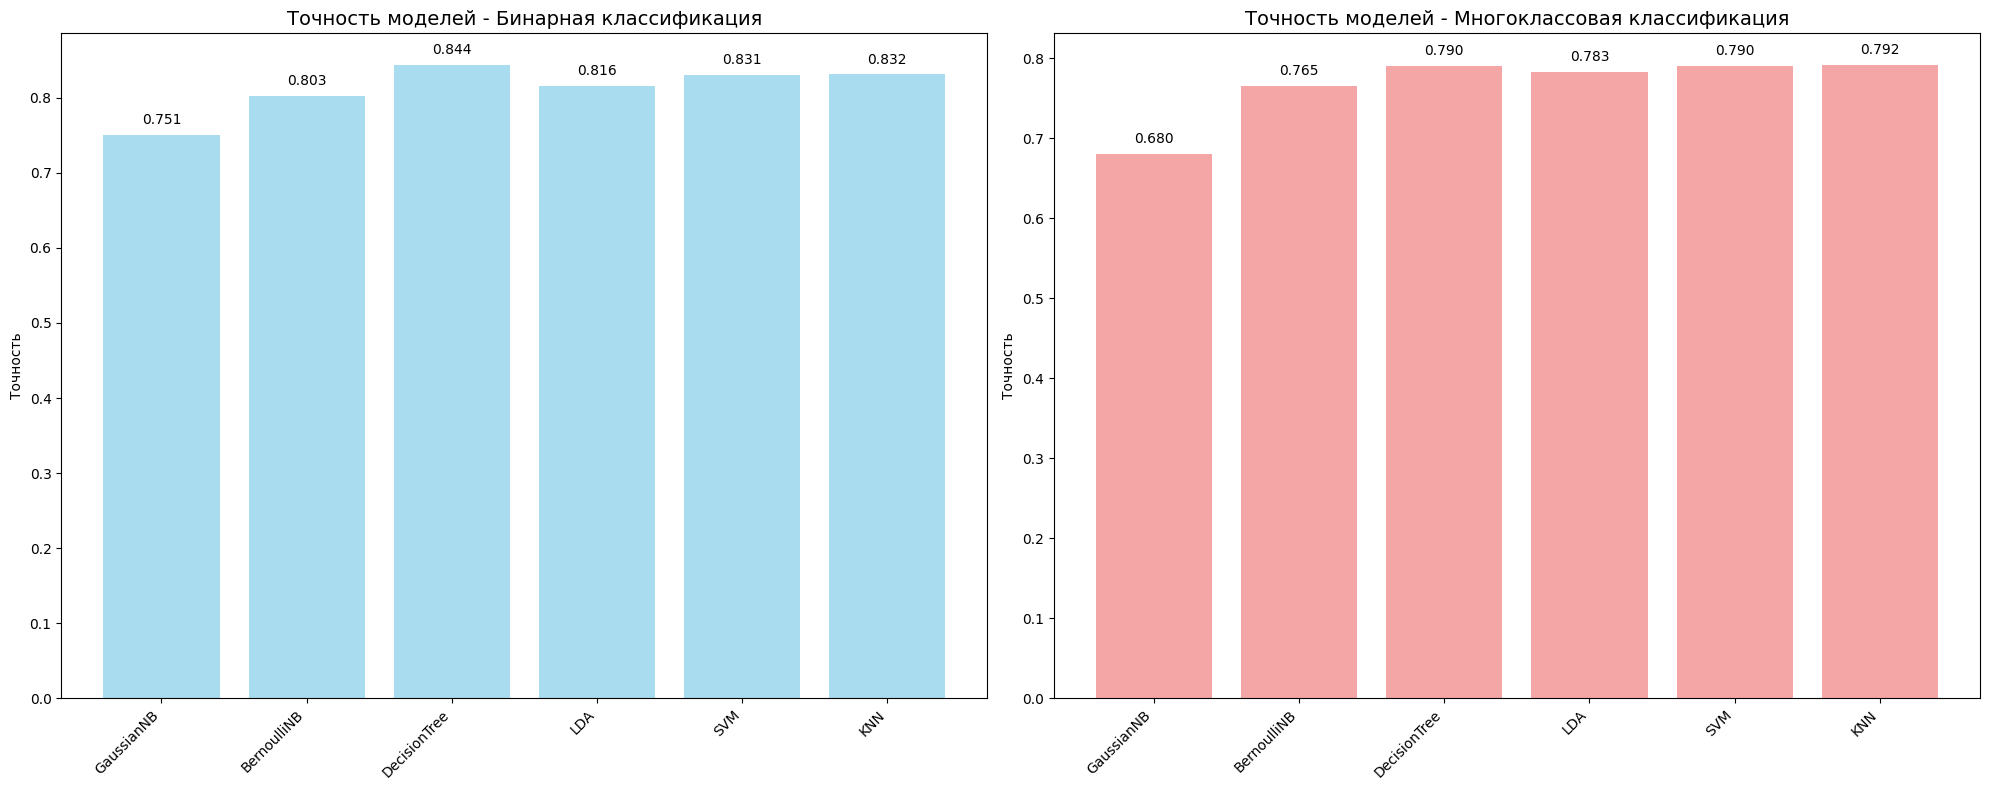

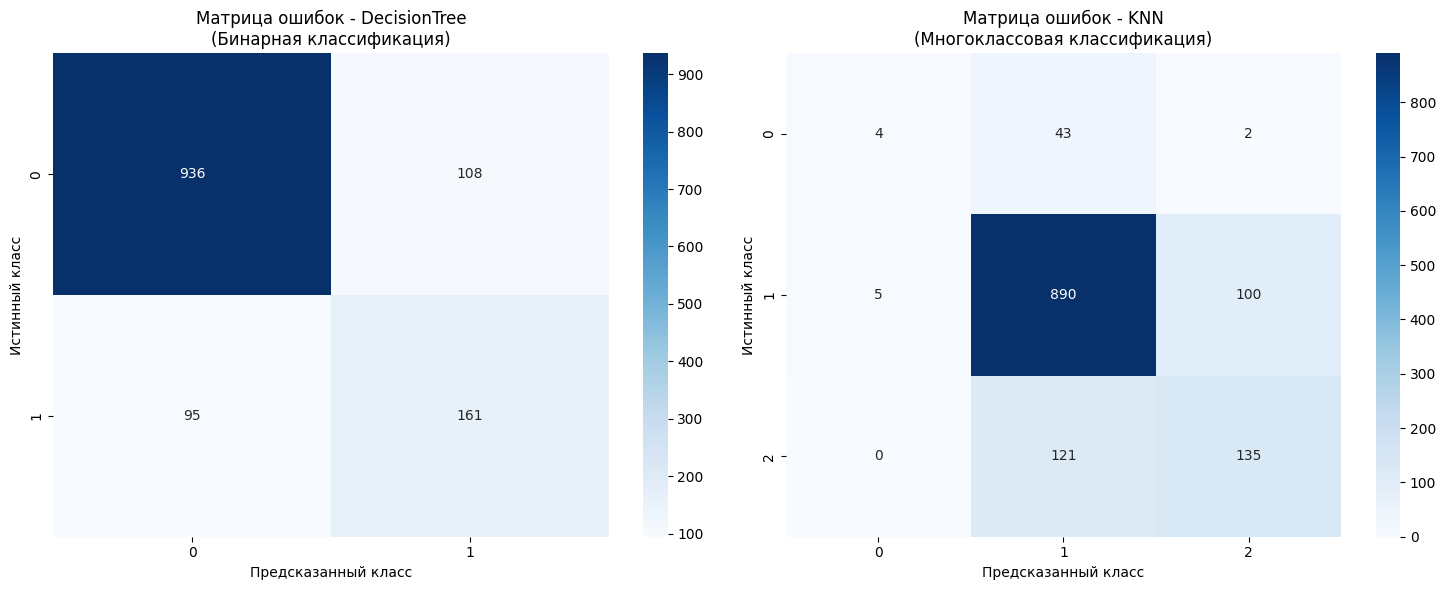

Лучшая модель для бинарной классификации: DecisionTree (точность: 0.8438)
Лучшая модель для многоклассовой классификации: KNN (точность: 0.7915)


In [16]:
# Сравнение точности моделей
def plot_comparison(results_binary, results_multi):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Бинарная классификация
    binary_acc = {name: res['accuracy'] for name, res in results_binary.items() if res is not None}
    models_binary = list(binary_acc.keys())
    accuracies_binary = list(binary_acc.values())
    
    bars1 = ax1.bar(models_binary, accuracies_binary, color='skyblue', alpha=0.7)
    ax1.set_title('Точность моделей - Бинарная классификация', fontsize=14)
    ax1.set_ylabel('Точность')
    ax1.set_xticklabels(models_binary, rotation=45, ha='right')
    
    # Добавление значений на столбцы
    for bar, acc in zip(bars1, accuracies_binary):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Многоклассовая классификация
    multi_acc = {name: res['accuracy'] for name, res in results_multi.items() if res is not None}
    models_multi = list(multi_acc.keys())
    accuracies_multi = list(multi_acc.values())
    
    bars2 = ax2.bar(models_multi, accuracies_multi, color='lightcoral', alpha=0.7)
    ax2.set_title('Точность моделей - Многоклассовая классификация', fontsize=14)
    ax2.set_ylabel('Точность')
    ax2.set_xticklabels(models_multi, rotation=45, ha='right')
    
    # Добавление значений на столбцы
    for bar, acc in zip(bars2, accuracies_multi):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_comparison(binary_results, multi_results)

# Матрицы ошибок для лучших моделей
def plot_best_models_confusion_matrix(binary_results, multi_results):
    # Находим лучшие модели
    best_binary = max([(name, res) for name, res in binary_results.items() if res is not None], 
                     key=lambda x: x[1]['accuracy'])
    best_multi = max([(name, res) for name, res in multi_results.items() if res is not None], 
                    key=lambda x: x[1]['accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Матрица ошибок для бинарной классификации
    cm_binary = confusion_matrix(y_test_binary, best_binary[1]['predictions'])
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Матрица ошибок - {best_binary[0]}\n(Бинарная классификация)')
    ax1.set_xlabel('Предсказанный класс')
    ax1.set_ylabel('Истинный класс')
    
    # Матрица ошибок для многоклассовой классификации
    cm_multi = confusion_matrix(y_test_multi, best_multi[1]['predictions'])
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title(f'Матрица ошибок - {best_multi[0]}\n(Многоклассовая классификация)')
    ax2.set_xlabel('Предсказанный класс')
    ax2.set_ylabel('Истинный класс')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Лучшая модель для бинарной классификации: {best_binary[0]} (точность: {best_binary[1]['accuracy']:.4f})")
    print(f"Лучшая модель для многоклассовой классификации: {best_multi[0]} (точность: {best_multi[1]['accuracy']:.4f})")

plot_best_models_confusion_matrix(binary_results, multi_results)

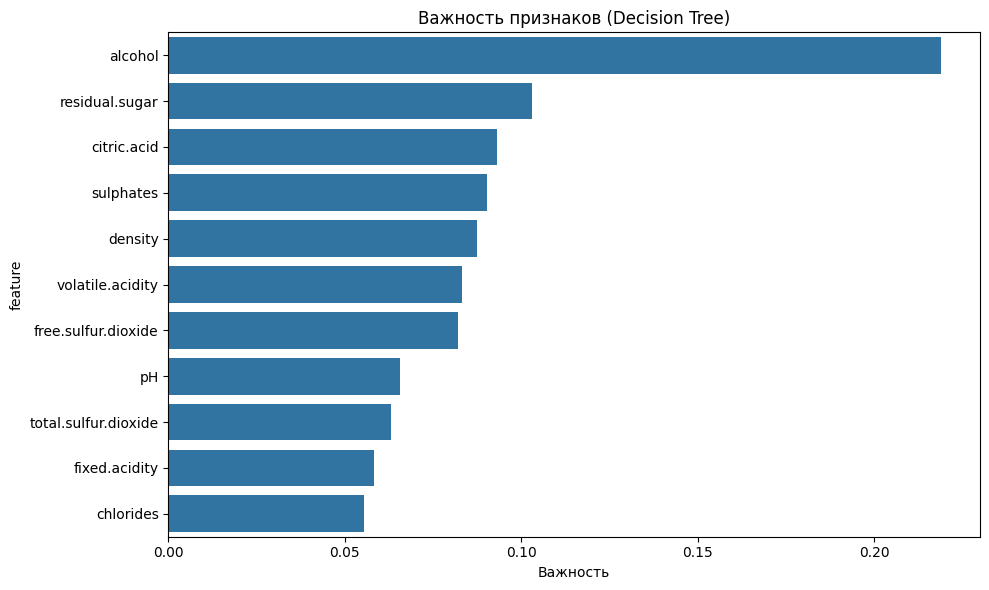

Важность признаков:
                 feature  importance
10               alcohol    0.218944
3         residual.sugar    0.103062
2            citric.acid    0.092978
9              sulphates    0.090221
7                density    0.087280
1       volatile.acidity    0.083113
5    free.sulfur.dioxide    0.082063
8                     pH    0.065692
6   total.sulfur.dioxide    0.063104
0          fixed.acidity    0.058164
4              chlorides    0.055379


In [17]:
# Анализ важности признаков с помощью дерева решений
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train_binary)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков (Decision Tree)')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

print("Важность признаков:")
print(feature_importance)

In [18]:
def create_final_report(binary_results, multi_results):
    print("="*80)
    print("ФИНАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ ВИНА")
    print("="*80)
    
    print("\nЛУЧШИЕ МОДЕЛИ:")
    
    # Лучшие модели для бинарной классификации
    valid_binary = [(name, res) for name, res in binary_results.items() if res is not None]
    best_binary = max(valid_binary, key=lambda x: x[1]['accuracy'])
    
    print(f"\nБинарная классификация (качество >= 7):")
    print(f"Лучшая модель: {best_binary[0]}")
    print(f"Точность: {best_binary[1]['accuracy']:.4f}")
    print(f"Кросс-валидация: {best_binary[1]['cv_mean']:.4f} (+/- {best_binary[1]['cv_std'] * 2:.4f})")
    
    # Лучшие модели для многоклассовой классификации
    valid_multi = [(name, res) for name, res in multi_results.items() if res is not None]
    best_multi = max(valid_multi, key=lambda x: x[1]['accuracy'])
    
    print(f"\nМногоклассовая классификация:")
    print(f"Лучшая модель: {best_multi[0]}")
    print(f"Точность: {best_multi[1]['accuracy']:.4f}")
    print(f"Кросс-валидация: {best_multi[1]['cv_mean']:.4f} (+/- {best_multi[1]['cv_std'] * 2:.4f})")
    
    print(f"\nРЕЙТИНГ МОДЕЛЕЙ:")
    
    print(f"\nБинарная классификация:")
    sorted_binary = sorted(valid_binary, key=lambda x: x[1]['accuracy'], reverse=True)
    for i, (name, res) in enumerate(sorted_binary, 1):
        print(f"{i}. {name}: {res['accuracy']:.4f}")
    
    print(f"\nМногоклассовая классификация:")
    sorted_multi = sorted(valid_multi, key=lambda x: x[1]['accuracy'], reverse=True)
    for i, (name, res) in enumerate(sorted_multi, 1):
        print(f"{i}. {name}: {res['accuracy']:.4f}")

create_final_report(binary_results, multi_results)

ФИНАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ ВИНА

ЛУЧШИЕ МОДЕЛИ:

Бинарная классификация (качество >= 7):
Лучшая модель: DecisionTree
Точность: 0.8438
Кросс-валидация: 0.8320 (+/- 0.0205)

Многоклассовая классификация:
Лучшая модель: KNN
Точность: 0.7915
Кросс-валидация: 0.7989 (+/- 0.0204)

РЕЙТИНГ МОДЕЛЕЙ:

Бинарная классификация:
1. DecisionTree: 0.8438
2. KNN: 0.8315
3. SVM: 0.8308
4. LDA: 0.8162
5. BernoulliNB: 0.8031
6. GaussianNB: 0.7508

Многоклассовая классификация:
1. KNN: 0.7915
2. DecisionTree: 0.7900
3. SVM: 0.7900
4. LDA: 0.7831
5. BernoulliNB: 0.7654
6. GaussianNB: 0.6800


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Модифицированная функция оценки моделей со всеми метриками
def evaluate_models_comprehensive(classifiers, X_train, X_test, y_train, y_test, problem_type="Binary"):
    results = {}
    
    for name, clf in classifiers.items():
        print(f"\n{'-'*60}")
        print(f"Оценка {name} для {problem_type} классификации")
        print(f"{'-'*60}")
        
        try:
            # Обучение модели
            if name in ['MultinomialNB', 'ComplementNB', 'BernoulliNB']:
                # Эти методы работают лучше с неотрицательными данными
                X_train_adj = X_train - X_train.min()
                X_test_adj = X_test - X_test.min()
                clf.fit(X_train_adj, y_train)
                y_pred = clf.predict(X_test_adj)
                y_pred_proba = clf.predict_proba(X_test_adj) if hasattr(clf, "predict_proba") else None
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_pred_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None
            
            # Расчет всех метрик
            accuracy = accuracy_score(y_test, y_pred)
            
            # Для многоклассовой классификации используем weighted average
            if problem_type == "Multi-class":
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            else:
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # ROC-AUC calculation
            roc_auc = None
            if y_pred_proba is not None:
                if problem_type == "Binary":
                    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
                else:
                    # Для многоклассовой используем micro-average
                    from sklearn.preprocessing import label_binarize
                    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
            
            cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
            
            print(f"Accuracy:    {accuracy:.4f}")
            print(f"Precision:   {precision:.4f}")
            print(f"Recall:      {recall:.4f}")
            print(f"F1-Score:    {f1:.4f}")
            if roc_auc is not None:
                print(f"ROC-AUC:     {roc_auc:.4f}")
            print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            
            results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'model': clf,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
        except Exception as e:
            print(f"Ошибка при обучении {name}: {e}")
            results[name] = None
    
    return results

# Оценка для бинарной классификации со всеми метриками
print("="*80)
print("БИНАРНАЯ КЛАССИФИКАЦИЯ - ВСЕ МЕТРИКИ")
print("="*80)
binary_results_comprehensive = evaluate_models_comprehensive(
    classifiers, X_train_scaled, X_test_scaled, y_train_binary, y_test_binary, "Binary"
)

# Оценка для многоклассовой классификации со всеми метриками
print("\n" + "="*80)
print("МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ - ВСЕ МЕТРИКИ")
print("="*80)
multi_results_comprehensive = evaluate_models_comprehensive(
    classifiers, X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi, "Multi-class"
)

БИНАРНАЯ КЛАССИФИКАЦИЯ - ВСЕ МЕТРИКИ

------------------------------------------------------------
Оценка GaussianNB для Binary классификации
------------------------------------------------------------
Accuracy:    0.7508
Precision:   0.4119
Recall:      0.6211
F1-Score:    0.4953
ROC-AUC:     0.7583
CV Accuracy: 0.7441 (+/- 0.0276)

------------------------------------------------------------
Оценка MultinomialNB для Binary классификации
------------------------------------------------------------
Ошибка при обучении MultinomialNB: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\batal\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, 

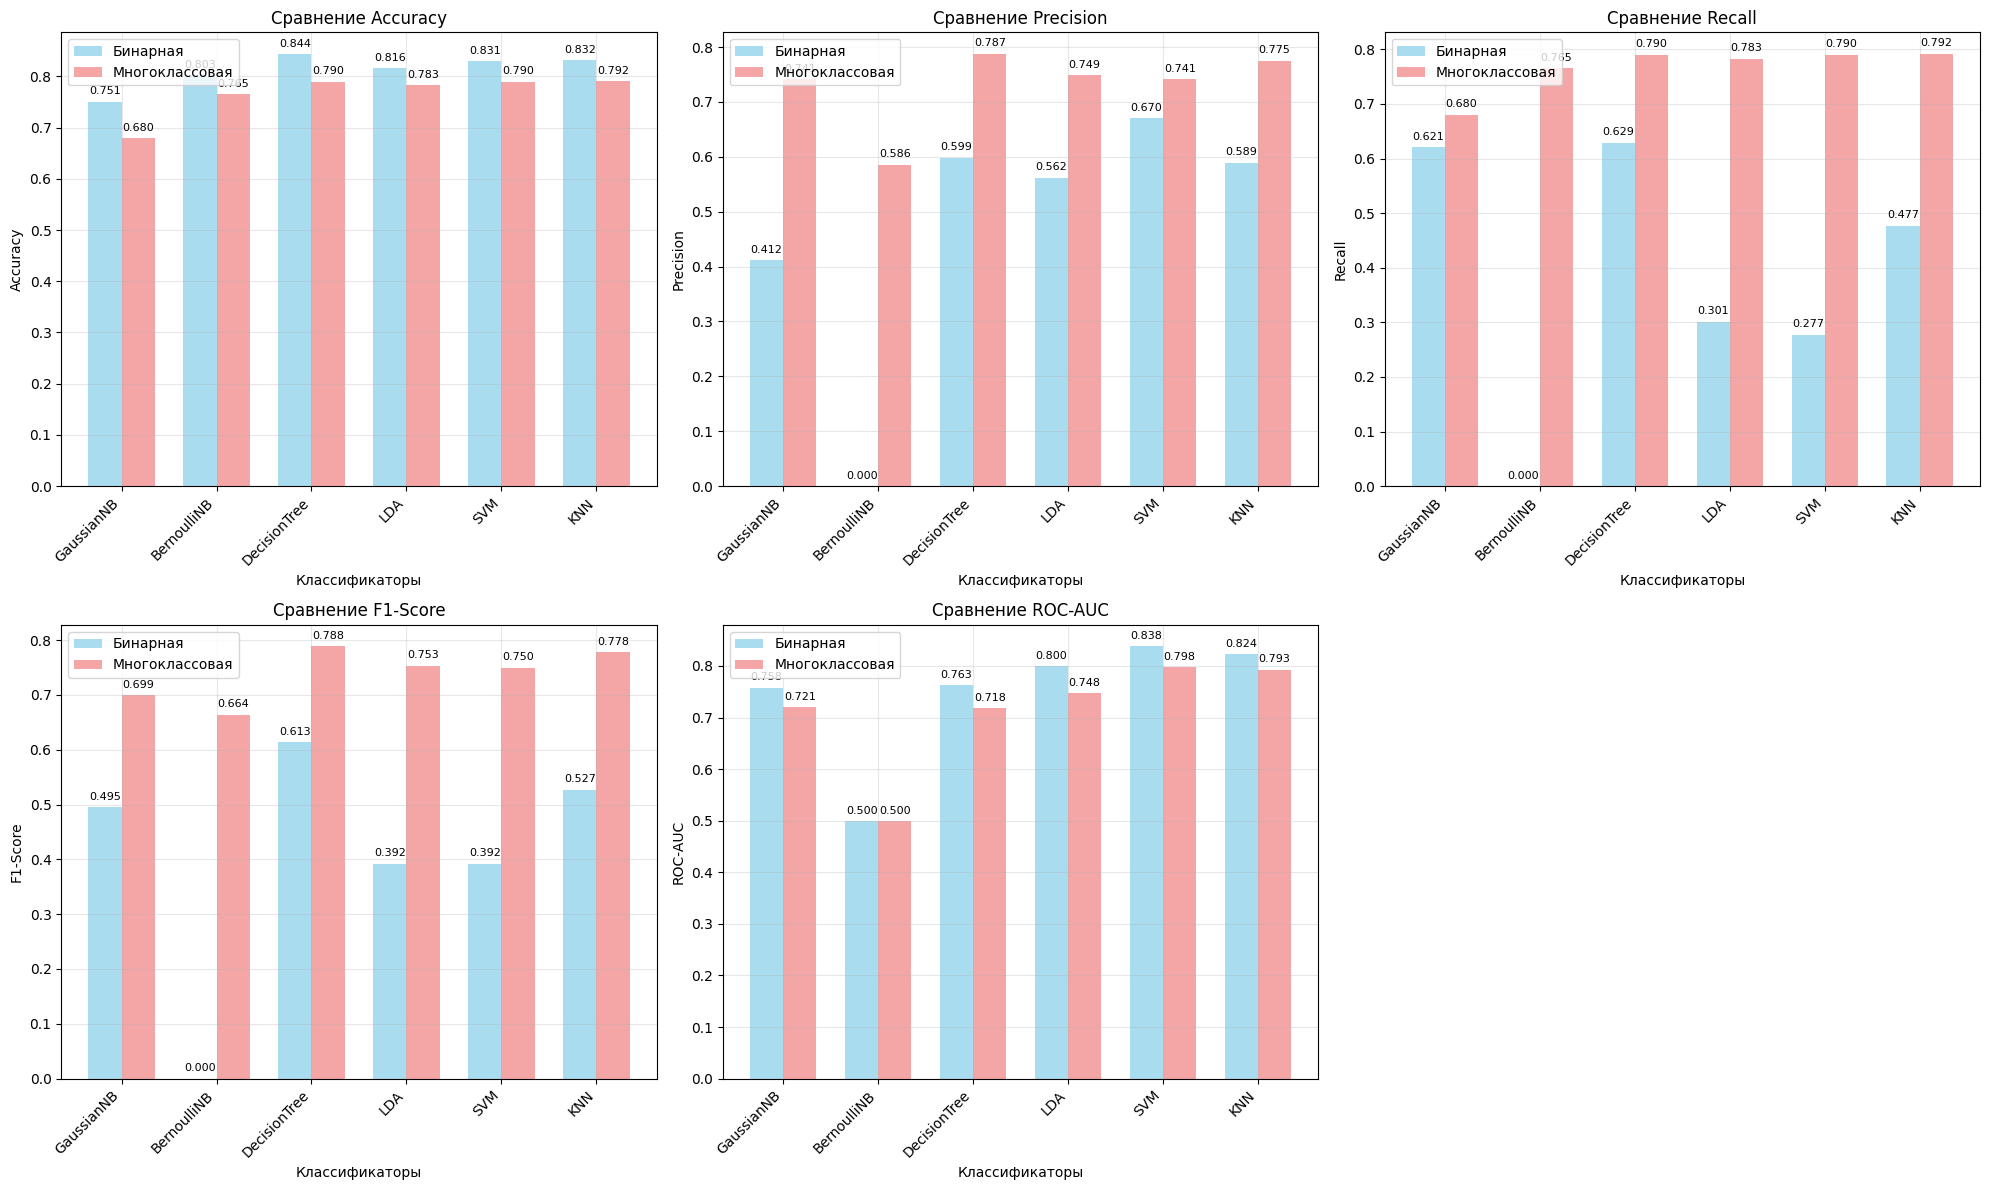

In [22]:
def plot_comprehensive_comparison(results_binary, results_multi):
    """Визуализация всех метрик для сравнения классификаторов"""
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        # Бинарная классификация
        binary_vals = []
        binary_names = []
        for name, res in results_binary.items():
            if res is not None and res[metric] is not None:
                binary_vals.append(res[metric])
                binary_names.append(name)
        
        # Многоклассовая классификация
        multi_vals = []
        multi_names = []
        for name, res in results_multi.items():
            if res is not None and res[metric] is not None:
                multi_vals.append(res[metric])
                multi_names.append(name)
        
        x = np.arange(len(binary_names))
        width = 0.35
        
        bars1 = axes[idx].bar(x - width/2, binary_vals, width, label='Бинарная', alpha=0.7, color='skyblue')
        bars2 = axes[idx].bar(x + width/2, multi_vals, width, label='Многоклассовая', alpha=0.7, color='lightcoral')
        
        axes[idx].set_xlabel('Классификаторы')
        axes[idx].set_ylabel(metric_name)
        axes[idx].set_title(f'Сравнение {metric_name}')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(binary_names, rotation=45, ha='right')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Добавление значений на столбцы
        for bar in bars1:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        for bar in bars2:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Удаляем последний пустой subplot
    if len(metrics) < len(axes):
        for i in range(len(metrics), len(axes)):
            fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

plot_comprehensive_comparison(binary_results_comprehensive, multi_results_comprehensive)

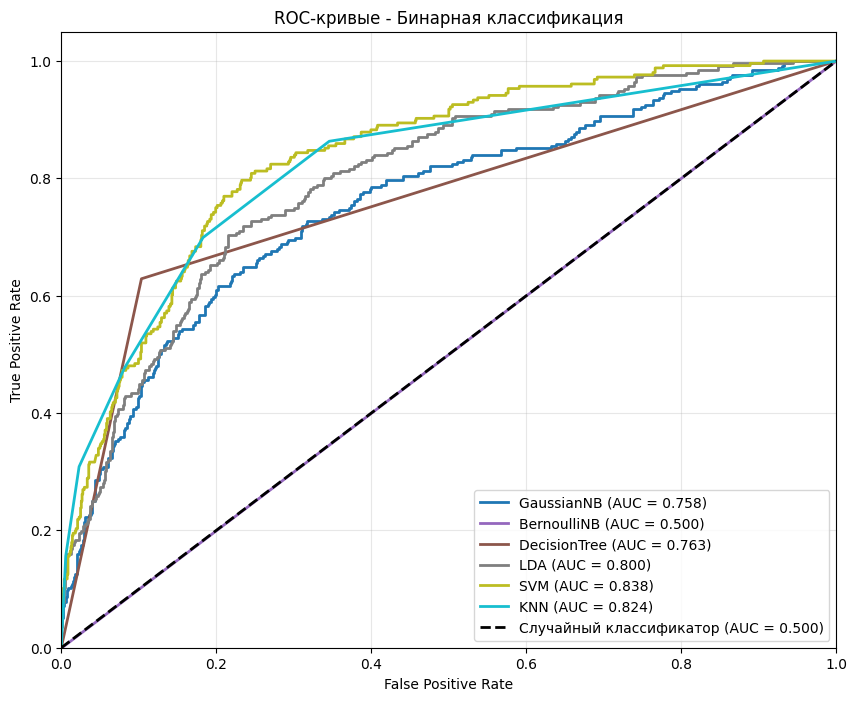

In [23]:
def plot_roc_curves(results_binary, y_test):
    """Построение ROC-кривых для всех классификаторов"""
    plt.figure(figsize=(10, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results_binary)))
    
    for (name, res), color in zip(results_binary.items(), colors):
        if res is not None and res['probabilities'] is not None and res['roc_auc'] is not None:
            fpr, tpr, _ = roc_curve(y_test, res['probabilities'][:, 1])
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUC = {res["roc_auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайный классификатор (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые - Бинарная классификация')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_curves(binary_results_comprehensive, y_test_binary)

In [24]:
def create_detailed_report(results_binary, results_multi):
    """Создание детального отчета со всеми метриками"""
    
    print("="*100)
    print("ДЕТАЛИЗИРОВАННЫЙ ОТЧЕТ ПО ВСЕМ МЕТРИКАМ")
    print("="*100)
    
    # Создаем DataFrame для удобного отображения
    report_data = []
    
    for name in classifiers.keys():
        if (name in results_binary and results_binary[name] is not None and 
            name in results_multi and results_multi[name] is not None):
            
            bin_res = results_binary[name]
            multi_res = results_multi[name]
            
            report_data.append({
                'Classifier': name,
                'Bin_Accuracy': f"{bin_res['accuracy']:.4f}",
                'Bin_Precision': f"{bin_res['precision']:.4f}",
                'Bin_Recall': f"{bin_res['recall']:.4f}",
                'Bin_F1': f"{bin_res['f1_score']:.4f}",
                'Bin_AUC': f"{bin_res['roc_auc']:.4f}" if bin_res['roc_auc'] else 'N/A',
                'Multi_Accuracy': f"{multi_res['accuracy']:.4f}",
                'Multi_Precision': f"{multi_res['precision']:.4f}",
                'Multi_Recall': f"{multi_res['recall']:.4f}",
                'Multi_F1': f"{multi_res['f1_score']:.4f}",
                'Multi_AUC': f"{multi_res['roc_auc']:.4f}" if multi_res['roc_auc'] else 'N/A'
            })
    
    report_df = pd.DataFrame(report_data)
    print(report_df.to_string(index=False))
    
    return report_df

detailed_report = create_detailed_report(binary_results_comprehensive, multi_results_comprehensive)

ДЕТАЛИЗИРОВАННЫЙ ОТЧЕТ ПО ВСЕМ МЕТРИКАМ
  Classifier Bin_Accuracy Bin_Precision Bin_Recall Bin_F1 Bin_AUC Multi_Accuracy Multi_Precision Multi_Recall Multi_F1 Multi_AUC
  GaussianNB       0.7508        0.4119     0.6211 0.4953  0.7583         0.6800          0.7409       0.6800   0.6993    0.7207
 BernoulliNB       0.8031        0.0000     0.0000 0.0000  0.4995         0.7654          0.5858       0.7654   0.6637    0.4995
DecisionTree       0.8438        0.5985     0.6289 0.6133  0.7627         0.7900          0.7874       0.7900   0.7885    0.7182
         LDA       0.8162        0.5620     0.3008 0.3919  0.8002         0.7831          0.7488       0.7831   0.7535    0.7477
         SVM       0.8308        0.6698     0.2773 0.3923  0.8379         0.7900          0.7410       0.7900   0.7496    0.7984
         KNN       0.8315        0.5894     0.4766 0.5270  0.8238         0.7915          0.7752       0.7915   0.7779    0.7930


In [25]:
def analyze_best_performing_models(results_binary, results_multi):
    """Анализ лучших моделей по каждой метрике"""
    
    print("\n" + "="*80)
    print("ЛУЧШИЕ МОДЕЛИ ПО КАЖДОЙ МЕТРИКЕ")
    print("="*80)
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    
    print("\n--- БИНАРНАЯ КЛАССИФИКАЦИЯ ---")
    valid_binary = {name: res for name, res in results_binary.items() if res is not None}
    
    for metric, metric_name in zip(metrics, metric_names):
        if any(res[metric] is not None for res in valid_binary.values()):
            best_model = max(valid_binary.items(), 
                           key=lambda x: x[1][metric] if x[1][metric] is not None else -1)
            print(f"{metric_name}: {best_model[0]} - {best_model[1][metric]:.4f}")
    
    print("\n--- МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ ---")
    valid_multi = {name: res for name, res in results_multi.items() if res is not None}
    
    for metric, metric_name in zip(metrics, metric_names):
        if any(res[metric] is not None for res in valid_multi.values()):
            best_model = max(valid_multi.items(), 
                           key=lambda x: x[1][metric] if x[1][metric] is not None else -1)
            print(f"{metric_name}: {best_model[0]} - {best_model[1][metric]:.4f}")

analyze_best_performing_models(binary_results_comprehensive, multi_results_comprehensive)


ЛУЧШИЕ МОДЕЛИ ПО КАЖДОЙ МЕТРИКЕ

--- БИНАРНАЯ КЛАССИФИКАЦИЯ ---
Accuracy: DecisionTree - 0.8438
Precision: SVM - 0.6698
Recall: DecisionTree - 0.6289
F1-Score: DecisionTree - 0.6133
ROC-AUC: SVM - 0.8379

--- МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ ---
Accuracy: KNN - 0.7915
Precision: DecisionTree - 0.7874
Recall: KNN - 0.7915
F1-Score: DecisionTree - 0.7885
ROC-AUC: SVM - 0.7984


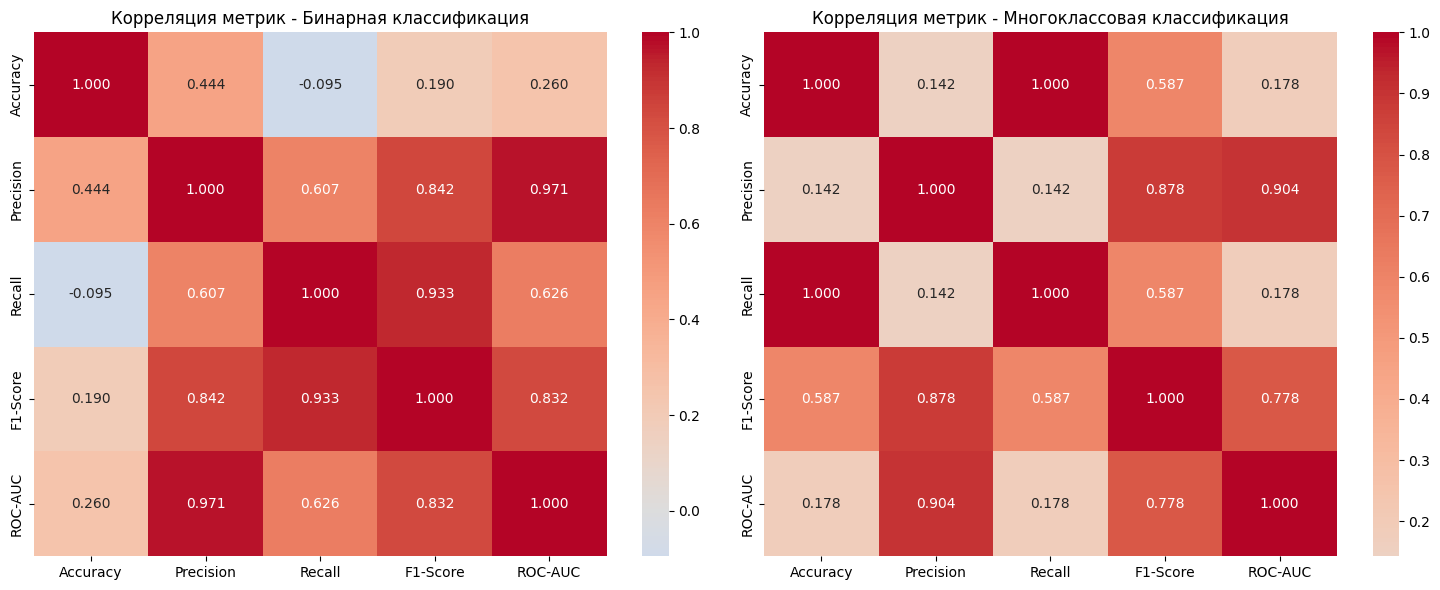

In [26]:
def plot_metrics_correlation(results_binary, results_multi):
    """Визуализация корреляции между метриками"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Для бинарной классификации
    binary_metrics_data = []
    for name, res in results_binary.items():
        if res is not None:
            binary_metrics_data.append([
                res['accuracy'],
                res['precision'], 
                res['recall'],
                res['f1_score'],
                res['roc_auc'] if res['roc_auc'] is not None else 0
            ])
    
    if binary_metrics_data:
        binary_corr = pd.DataFrame(binary_metrics_data, 
                                 columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']).corr()
        sns.heatmap(binary_corr, annot=True, cmap='coolwarm', center=0, ax=ax1, fmt='.3f')
        ax1.set_title('Корреляция метрик - Бинарная классификация')
    
    # Для многоклассовой классификации
    multi_metrics_data = []
    for name, res in results_multi.items():
        if res is not None:
            multi_metrics_data.append([
                res['accuracy'],
                res['precision'], 
                res['recall'],
                res['f1_score'],
                res['roc_auc'] if res['roc_auc'] is not None else 0
            ])
    
    if multi_metrics_data:
        multi_corr = pd.DataFrame(multi_metrics_data, 
                                columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']).corr()
        sns.heatmap(multi_corr, annot=True, cmap='coolwarm', center=0, ax=ax2, fmt='.3f')
        ax2.set_title('Корреляция метрик - Многоклассовая классификация')
    
    plt.tight_layout()
    plt.show()

plot_metrics_correlation(binary_results_comprehensive, multi_results_comprehensive)

In [28]:
def final_comparative_analysis(results_binary, results_multi):
    """Финальный сравнительный анализ всех классификаторов"""
    
    print("="*100)
    print("ФИНАЛЬНЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
    print("="*100)
    
    # Рассчитываем средний ранг для каждого классификатора
    classifiers_rank = {}
    
    for name in classifiers.keys():
        if (name in results_binary and results_binary[name] is not None and 
            name in results_multi and results_multi[name] is not None):
            
            bin_rank = 0
            multi_rank = 0
            metrics_count = 0
            
            # Ранжируем по всем метрикам для бинарной классификации
            for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
                if results_binary[name][metric] is not None:
                    all_scores = [res[metric] for res in results_binary.values() 
                                if res is not None and res[metric] is not None]
                    rank = sorted(all_scores, reverse=True).index(results_binary[name][metric]) + 1
                    bin_rank += rank
                    metrics_count += 1
            
            # Ранжируем по всем метрикам для многоклассовой классификации
            for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
                if results_multi[name][metric] is not None:
                    all_scores = [res[metric] for res in results_multi.values() 
                                if res is not None and res[metric] is not None]
                    rank = sorted(all_scores, reverse=True).index(results_multi[name][metric]) + 1
                    multi_rank += rank
                    metrics_count += 1
            
            # Средний ранг
            avg_rank = (bin_rank + multi_rank) / metrics_count if metrics_count > 0 else float('inf')
            classifiers_rank[name] = avg_rank
    
    # Сортируем по среднему рангу
    sorted_classifiers = sorted(classifiers_rank.items(), key=lambda x: x[1])
    
    print("\nРЕЙТИНГ КЛАССИФИКАТОРОВ (чем меньше ранг, тем лучше):")
    for i, (name, rank) in enumerate(sorted_classifiers, 1):
        print(f"{i}. {name}: средний ранг = {rank:.2f}")
    
    best_overall = sorted_classifiers[0][0]
    print(f"\nОБЩИЙ ЛУЧШИЙ КЛАССИФИКАТОР: {best_overall}")
    
    return sorted_classifiers

final_ranking = final_comparative_analysis(binary_results_comprehensive, multi_results_comprehensive)

ФИНАЛЬНЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ

РЕЙТИНГ КЛАССИФИКАТОРОВ (чем меньше ранг, тем лучше):
1. DecisionTree: средний ранг = 2.00
2. KNN: средний ранг = 2.00
3. SVM: средний ранг = 2.70
4. LDA: средний ранг = 3.70
5. GaussianNB: средний ранг = 4.70
6. BernoulliNB: средний ранг = 5.70

ОБЩИЙ ЛУЧШИЙ КЛАССИФИКАТОР: DecisionTree
